## Piepline implementation

In [3]:
# filepath: /home/iwaniukooo/Documents/Projects/biometria-iris/Biometric-Iris-Recognition/iris_pipeline.py

import cv2
import numpy as np
import matplotlib.pyplot as plt

class IrisPipeline:
    def __init__(self, path, debug = False):
        self.path = path
        self.img_original = None
        self.img_rgb = None
        self.gray = None
        self.binary = None
        self.new_center = None
        self.new_radius = None
        self.average_projection = None
        self.pupil_radius = None
        self.iris_rect = None
        self.pupil_threshold = 20
        self.mean_annular = None
        self.debug = debug

    def load_image(self):
        # Load the image and convert it to RGB
        self.img_original = cv2.imread(self.path)
        self.img_rgb = cv2.cvtColor(self.img_original, cv2.COLOR_BGR2RGB)

        # Center crop the image
        h, w, _ = self.img_rgb.shape
        crop_size = int(min(h, w) * 0.75)  # Crop to 60% of the smaller dimension
        center_x, center_y = w // 2, h // 2
        x1 = max(center_x - crop_size // 2, 0)
        y1 = max(center_y - crop_size // 2, 0)
        x2 = min(center_x + crop_size // 2, w)
        y2 = min(center_y + crop_size // 2, h)
        self.img_rgb = self.img_rgb[y1:y2, x1:x2]

    def preprocess(self):
        # Convert to grayscale
        self.gray = cv2.cvtColor(self.img_rgb, cv2.COLOR_BGR2GRAY)
        # Binarize to find the pupil
        _, binary_inv = cv2.threshold(self.gray, self.pupil_threshold, 255, cv2.THRESH_BINARY_INV)
        # Morphological closing
        kernel_close = np.ones((5,5), np.uint8)
        closed = cv2.morphologyEx(binary_inv, cv2.MORPH_CLOSE, kernel_close, iterations=2)
        # Remove small noise
        kernel_open = np.ones((3,3), np.uint8)
        self.binary = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=10)

    def find_pupil(self):
        # Projections to find approximate center
        h, w = self.binary.shape
        vertical_projection = np.sum(self.binary, axis=1)
        horizontal_projection = np.sum(self.binary, axis=0)

        vertical_center = np.argmax(vertical_projection)
        horizontal_center = np.argmax(horizontal_projection)

        v_max_1, v_min_1 = vertical_center, vertical_center
        h_max_1, h_min_1 = horizontal_center, horizontal_center

        # Find the boundary in vertical direction
        for i in range(vertical_center, h):
            if self.binary[i, horizontal_center] == 0:
                v_max_1 = i
                break
        for i in range(vertical_center, -1, -1):
            if self.binary[i, horizontal_center] == 0:
                v_min_1 = i
                break

        # Same for horizontal direction
        for j in range(horizontal_center, w):
            if self.binary[vertical_center, j] == 0:
                h_max_1 = j
                break
        for j in range(horizontal_center, -1, -1):
            if self.binary[vertical_center, j] == 0:
                h_min_1 = j
                break

        # Another way to find final min/max
        vertical_max_freq = vertical_projection[vertical_center]
        horizonal_max_freq = horizontal_projection[horizontal_center]
        v_max, v_min, h_max, h_min = v_max_1, v_min_1, h_max_1, h_min_1

        for j in range(vertical_center, h):
            if vertical_projection[j] < vertical_max_freq * 0.2:
                v_max = j
                break
        for j in range(vertical_center, -1, -1):
            if vertical_projection[j] < vertical_max_freq * 0.2:
                v_min = j
                break
        for j in range(horizontal_center, w):
            if horizontal_projection[j] < horizonal_max_freq * 0.2:
                h_max = j
                break
        for j in range(horizontal_center, -1, -1):
            if horizontal_projection[j] < horizonal_max_freq * 0.2:
                h_min = j
                break

        # Compute radius and center
        self.new_radius = (v_max - v_min + h_max - h_min) // 4
        self.new_center = ((h_max + h_min) // 2, (v_max + v_min) // 2)

    def enhance_image(self):
        # Create mask and set inside circle to white
        mask = np.zeros_like(self.img_rgb)
        cv2.circle(mask, self.new_center, self.new_radius+2, (255,255,255), -1)
        img_with_pupil = self.img_rgb.copy()
        img_with_pupil[mask > 0] = 255
        #plot img_with_pupil
        if self.debug:
            plt.imshow(img_with_pupil)
            plt.title("Image with Pupil")
            plt.axis('off')
            plt.show()
        
        #enhanced_image is img_with_pupil minus mean + 128 and clip
        mean = np.mean(img_with_pupil)
        enhanced_img = img_with_pupil.astype(np.float32) - mean + 128
        enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
        
        gamma = 0.75
        enhanced_img = np.power(enhanced_img / 255.0, gamma) * 255
        enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)
        if self.debug:
            plt.imshow(enhanced_img)
            plt.title("Enhanced Image")
            plt.axis('off')
            plt.show()

        return enhanced_img
        
        # return img_with_pupil

    def calculate_mean_annular(self, enhanced_img):
        if len(enhanced_img.shape) == 3:  # If the image has 3 channels (color)
            enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2GRAY)
        _new_radius = self.new_radius+5
        # Create a mask for the larger circle (new_radius + 2)
        h, w = enhanced_img.shape
        y, x = np.ogrid[:h, :w]
        distance_from_center = np.sqrt((x - self.new_center[0])**2 + (y - self.new_center[1])**2)

        # Mask for the larger circle
        mask_large = distance_from_center <= (_new_radius +10)

        # Mask for the smaller circle
        mask_small = distance_from_center <= _new_radius

        # Subtract the smaller circle mask from the larger circle mask to get the annular region
        mask_annular = mask_large & ~mask_small

        # Calculate the mean pixel value in the annular region
        mean_annular = np.mean(enhanced_img[mask_annular])
        self.mean_annular = mean_annular

    def threshold_and_projection(self, enhanced_img):
        # Use the pupil center and radius calculated in find_pupil
        cx, cy = self.new_center
        r = self.new_radius
        self.calculate_mean_annular(enhanced_img)
        # mean_val = self._calculate_mean_on_horizontal_line(enhanced_img, cx, cy, r)
        _, binary_thresh = cv2.threshold(
            enhanced_img,
            # min(
            # 5 * mean_val, 220),
            self.mean_annular+12,
            255,
            cv2.THRESH_BINARY
        )

        # kernel2 = np.ones((2,2), np.uint8)
        # closing = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel2, iterations=4)
        # gray_bin = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)

        # UNCOMMENT TO SEE THRESHOLD EFFECT
        # self.calculate_mean_annular(binary_thresh)
        if self.debug:
            plt.imshow(binary_thresh, cmap='gray')
            plt.title(f"Binary Threshold Image {self.mean_annular}")
            plt.axis('off')
            plt.show()

        
        # TODO: check these angles on image (should be on the bottom IMO)
        # angle_start, angle_end = 120, 60
        # angle_start, angle_end = 20, 40
        # angle_start, angle_end = 30, 50
        angle_start, angle_end = 90, 50
        
        binary_thresh=cv2.cvtColor(binary_thresh, cv2.COLOR_BGR2GRAY)
        projection = self._calculate_projection(binary_thresh, self.new_center, angle_start, angle_end)
        # self.average_projection = int(np.mean(projection))
        self.average_projection=int(np.max(projection))
        # projection=sorted(projection,reverse=True)
        # projection_10=projection[5]
        # self.average_projection=projection_10
        return binary_thresh


    def _calculate_mean_on_horizontal_line(self, img, cx, cy, r):
        outer_radius = int(1.2 * (r + 2))
        inner_radius = r + 2
        x_min = max(0, cx - outer_radius)
        x_max = min(img.shape[1], cx + outer_radius)
        pixel_values = []
        for x in range(x_min, x_max):
            distance = abs(x - cx)
            if inner_radius < distance <= outer_radius:
                pixel_values.append(img[cy, x])
        return np.mean(pixel_values) if pixel_values else 0

    def _calculate_projection(self, gray_image, center, angle_start, angle_end, num_lines=100):
        h, w = gray_image.shape
        projection = []
        angles = np.linspace(np.radians(angle_start), np.radians(angle_end), num_lines)
        for angle in angles:
            dx = np.cos(angle)
            dy = np.sin(angle)
            line_sum = 0
            for r in range(max(h, w)):
                x = int(center[0] + r * dx)
                y = int(center[1] + r * dy)
                distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
                
                if 0 <= x < w and 0 <= y < h and distance <= self.new_radius *2.5:
                    line_sum += 1 if gray_image[y, x] == 0 else 0
                else:
                    break
            projection.append(line_sum)
        return projection

    def create_rectangular_iris(self):
        # Construct the IrisProcessor-like functionality
        pupil_radius = self.new_radius
        iris_radius = self.new_radius + self.average_projection
        # Ensure grayscale
        if len(self.img_original.shape) > 2:
            working_img = self.img_original[:,:,0]
        else:
            working_img = self.img_original
        self.iris_rect = np.ones((1,1)) # placeholder

        # Create mask for iris
        rows, cols = working_img.shape
        y_grid, x_grid = np.ogrid[:rows, :cols]
        dist_from_center = np.sqrt((x_grid - self.new_center[0])**2 + (y_grid - self.new_center[1])**2)
        mask_iris = (dist_from_center >= pupil_radius) & (dist_from_center <= iris_radius)

        width = int(2 * np.pi * iris_radius)
        height = int(iris_radius - pupil_radius)
        height = max(height, 1)
        self.iris_rect = np.ones((height, width)) * 128

        coords = np.argwhere(mask_iris)
        for y, x in coords:
            r = np.sqrt((x - self.new_center[0])**2 + (y - self.new_center[1])**2)
            dx = (x - self.new_center[0]) / r if r else 0
            dy = (y - self.new_center[1]) / r if r else 0
            theta = np.arctan2(dy, dx)
            if theta < 0: theta += 2*np.pi
            rect_y = int(r - pupil_radius)
            rect_y = max(min(height - 1, rect_y), 0)
            rect_x = int(theta * iris_radius)
            rect_x = max(min(width - 1, rect_x), 0)
            self.iris_rect[rect_y, rect_x] = working_img[y, x]

    def run_pipeline(self):
        self.load_image()
        self.preprocess()
        self.find_pupil()
        enhanced = self.enhance_image()
        self.threshold_and_projection(enhanced)
        self.create_rectangular_iris()
        
    def get_circle_img(self):
        # Draw the pupil circle on the original image
        img_with_circle = self.img_rgb.copy()
        cv2.circle(img_with_circle, self.new_center, self.new_radius, (255, 0, 0), 2)
        cv2.circle(img_with_circle, self.new_center, self.new_radius + self.average_projection, (0, 255, 0), 2)
        return img_with_circle
    
    @staticmethod
    def compare_rectangles(rect_1, rect_2):
        """
        Compare two iris rectangles by resizing them to the same dimensions and calculating MSE.
        
        :param rect_1: First iris rectangle (2D numpy array).
        :param rect_2: Second iris rectangle (2D numpy array).
        :return: Mean Squared Error (MSE) between the two rectangles.
        """
        # Get the dimensions of both rectangles
        height_1, width_1 = rect_1.shape
        height_2, width_2 = rect_2.shape

        # Determine the maximum width and height
        max_height = max(height_1, height_2)
        max_width = max(width_1, width_2)
        
        print(f"Max height: {max_height}, Max width: {max_width}")

        # Function to pad an image to the target size
        def pad_to_size(image, target_height, target_width):
            padded_image = np.full((target_height, target_width), 128, dtype=image.dtype)  # Fill with gray (128)
            padded_image[:image.shape[0], :image.shape[1]] = image
            return padded_image

        # Pad both rectangles to the same size
        rect_1_padded = pad_to_size(rect_1, max_height, max_width)
        rect_2_padded = pad_to_size(rect_2, max_height, max_width)

        # Calculate the Mean Squared Error (MSE)
        mse = np.mean((rect_1_padded - rect_2_padded) ** 2)
        return mse
    @staticmethod
    def compare_rectangles_fourier(rect_1, rect_2):
        """
        Compare two iris rectangles using Fourier Transform similarity.
        :param rect_1: First iris rectangle (2D numpy array).
        :param rect_2: Second iris rectangle (2D numpy array).
        :return: Normalized cross-correlation of Fourier magnitudes.
        """
        # Compute the Fourier Transform of both rectangles
        f1 = np.fft.fft2(rect_1)
        f2 = np.fft.fft2(rect_2)

        # Compute the magnitude spectra
        mag1 = np.abs(f1)
        mag2 = np.abs(f2)

        # Normalize the magnitude spectra
        mag1 = mag1 / np.max(mag1)
        mag2 = mag2 / np.max(mag2)

        # Compute the normalized cross-correlation
        correlation = np.sum(mag1 * mag2) / np.sqrt(np.sum(mag1**2) * np.sum(mag2**2))
        return correlation

    def get_results(self):
        return {
            "pupil_center": self.new_center,
            "pupil_radius": self.new_radius,
            "iris_radius": self.new_radius + self.average_projection,
            "iris_rectangle": self.iris_rect
        }

## Pipeline test

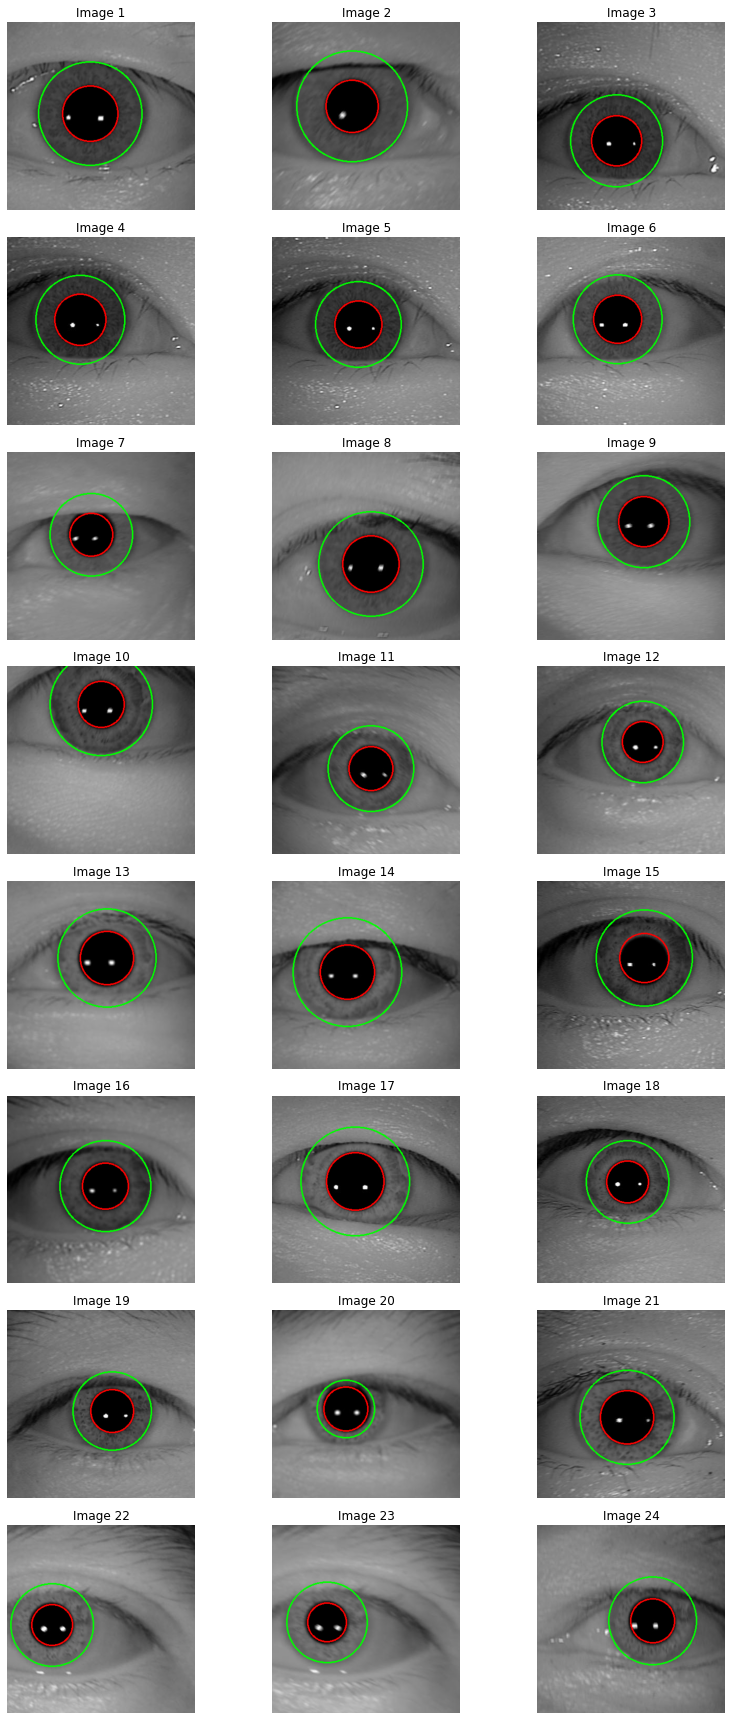

In [4]:
# Initialize a list to store pipelines and their circle images
pipelines = []
circle_images = []

# Loop through folders 000 to 011 and process one image from each
for i in range(24):
    folder = f"data/{i:03d}/"
    image_path = folder + f"S60{i:02d}S00.jpg"  # Assuming the image name follows this pattern
    pipeline = IrisPipeline(image_path)
    pipeline.run_pipeline()
    pipelines.append(pipeline)
    circle_images.append(pipeline.get_circle_img())

# Plot the results in a 4x3 grid
plt.figure(figsize=(12, 24))  # Set the figure size

for idx, img in enumerate(circle_images):
    
    plt.subplot(8, 3, idx + 1)  # 4 rows, 3 columns, current subplot
    plt.title(f"Image {idx + 1}")
    plt.imshow(img)
    plt.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Normalization of the segmented Iris

In [5]:
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Georgia", "DejaVu Serif", "serif"],  # Fallback options
    "font.size": 12,  # Increase font size
    "axes.titlesize": 14,  # Increase title size
    "axes.labelsize": 12,  # Increase axis label size
    "xtick.labelsize": 10,  # Set x-axis tick label size
    "ytick.labelsize": 10,  # Set y-axis tick label size
    "figure.dpi": 120,  # Increase resolution
})

In [2]:
from normalization import daugman_normalization, daugman_normalization_modified

Normalization


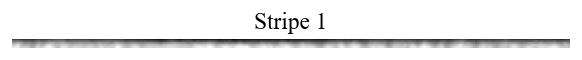

Stripe 1 shape:  (5, 300)


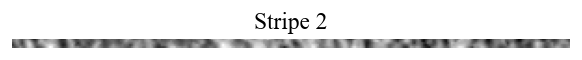

Stripe 2 shape:  (5, 300)


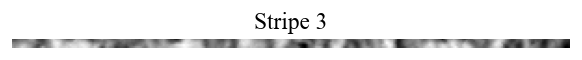

Stripe 3 shape:  (5, 300)


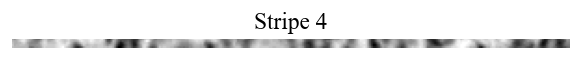

Stripe 4 shape:  (5, 300)


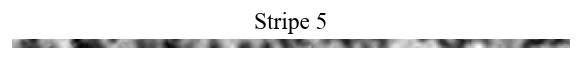

Stripe 5 shape:  (5, 300)


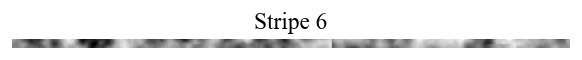

Stripe 6 shape:  (5, 300)


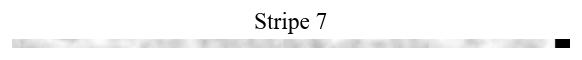

Stripe 7 shape:  (5, 300)


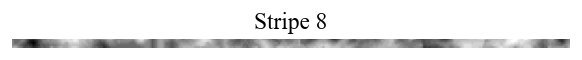

Stripe 8 shape:  (5, 300)


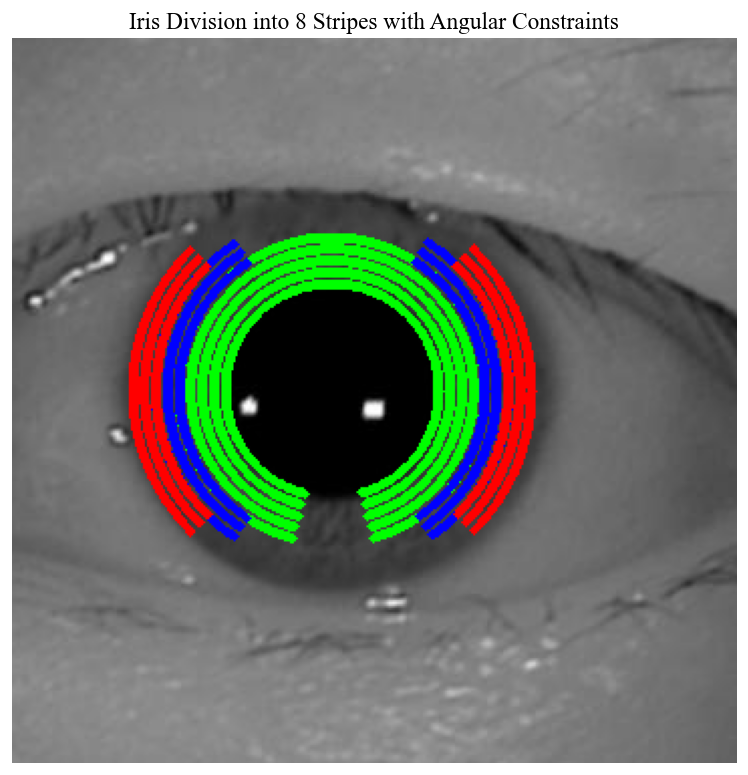

In [10]:
pipeline_foo = IrisPipeline("data/000/S6000S00.jpg")
pipeline_foo.run_pipeline()
results_foo = pipeline_foo.get_results()
pupil_center = results_foo["pupil_center"]
pupil_radius = results_foo["pupil_radius"]
iris_radius = results_foo["iris_radius"]
print("Normalization")

normalized_matrix = daugman_normalization_modified(pipeline_foo.gray, pupil_center, pupil_radius, iris_radius, debug=True)

### Number of pixels in each stripe

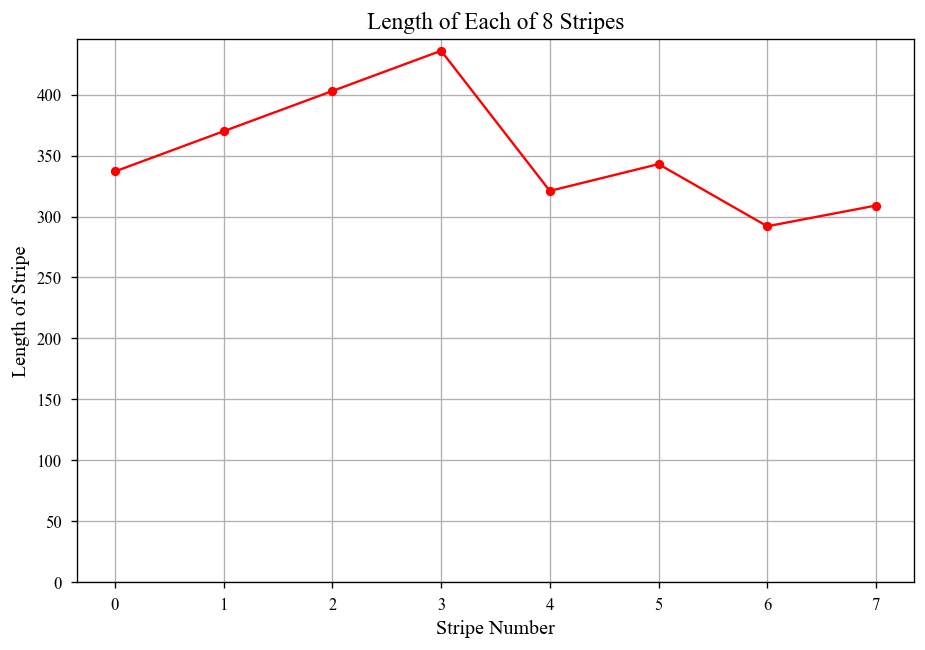

In [8]:
plt.figure(figsize=(9, 6))
plt.plot([i for i in range(len(normalized_matrix))], [len(stripe) for stripe in normalized_matrix], 'ro-')
plt.title("Length of Each of 8 Stripes")
plt.xlabel("Stripe Number")
plt.ylabel("Length of Stripe")
plt.ylim(0, max(len(stripe) for stripe in normalized_matrix) + 10)  # Set Y axis limits
plt.grid()
plt.show()

### Unwrapped iris

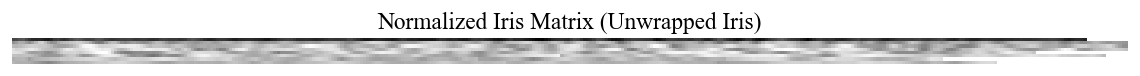

In [9]:
normalized_matrix_cut = []
for stripe in normalized_matrix:
    if len(stripe) > 350:
        normalized_matrix_cut.append(stripe[:350])
    else:
        normalized_matrix_cut.append(stripe + [np.max([np.max(s) for s in normalized_matrix])] * (350 - len(stripe)))

# Imshow
plt.figure(figsize=(12, 6))
plt.imshow(normalized_matrix_cut, cmap='gray')
plt.title("Normalized Iris Matrix (Unwrapped Iris)")
plt.axis('off')
plt.show()

## Iris Encoding

In [1]:
from encoding import encode_iris, resample_stripe, encode_iris_book, enhanced_iris_encoder

Iris Code Shape: (16, 128)
Iris Code (first 20 bits): [0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0]


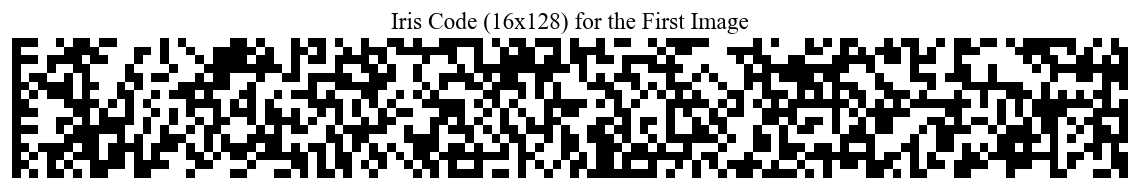

In [6]:
pipeline_foo = IrisPipeline("data/000/S6000S00.jpg")
pipeline_foo.run_pipeline()
results_foo = pipeline_foo.get_results()
pupil_center = results_foo["pupil_center"]
pupil_radius = results_foo["pupil_radius"]
iris_radius = results_foo["iris_radius"]

normalized_matrix = daugman_normalization_modified(pipeline_foo.gray, pupil_center, pupil_radius, iris_radius, debug=False)

iris_code = enhanced_iris_encoder(normalized_matrix, base_freq=0.5)
print("Iris Code Shape:", iris_code.shape)
print("Iris Code (first 20 bits):", iris_code.flatten()[:20])

plt.figure(figsize=(12, 6))
plt.imshow(iris_code, cmap='gray')
plt.title("Iris Code (16x128) for the First Image")
plt.axis('off')
plt.show()

### How close are the codes for the same person?

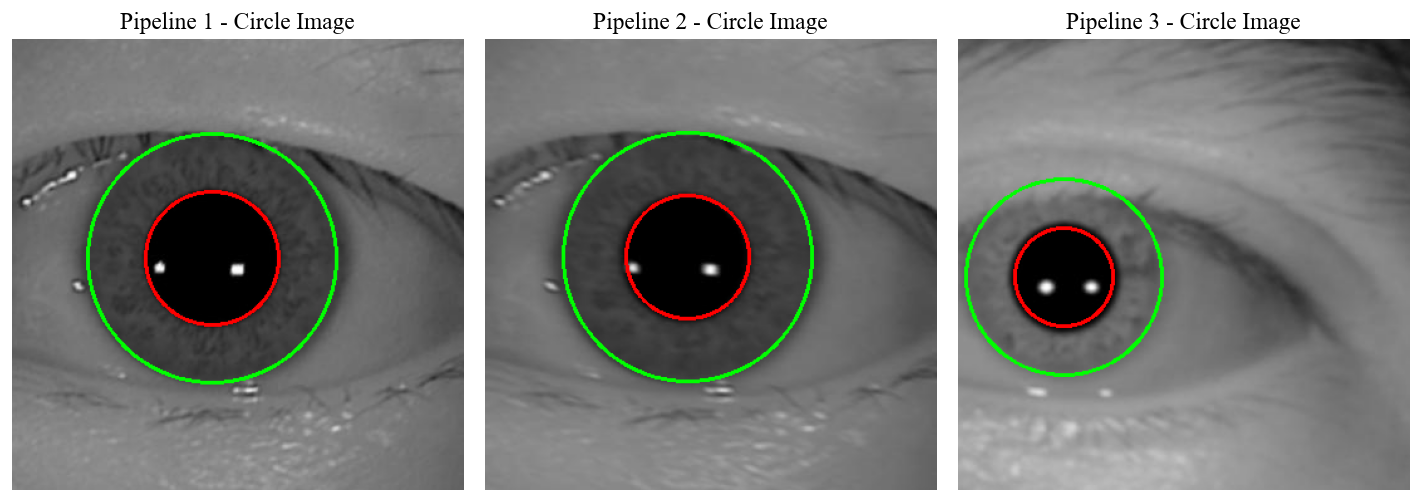

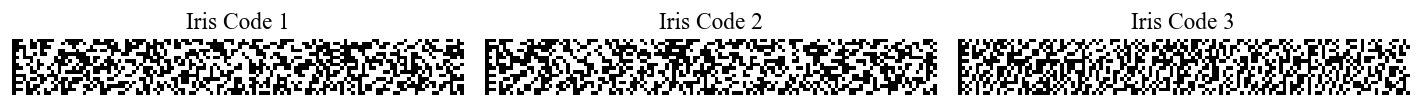

Hamming Distance (000/S6000S00.jpg to 000/S6000S01.jpg): 0.4224 (Same person)
Hamming Distance (000/S6000S00.jpg to 001/S6001S00.jpg): 0.5005 (Different person)


In [7]:
from utils import hamming_distance

base_freq = 0.5
num_scales = 10

# Run pipeline for the three images
pipeline_1 = IrisPipeline("data/000/S6000S00.jpg")
pipeline_1.run_pipeline()
results_1 = pipeline_1.get_results()
normalized_matrix_1 = daugman_normalization_modified(pipeline_1.gray, results_1["pupil_center"], results_1["pupil_radius"], results_1["iris_radius"])
iris_code_1 = enhanced_iris_encoder(normalized_matrix_1, base_freq=base_freq, num_scales=num_scales)
# iris_code_1 = encode_iris(normalized_matrix_1, f=base_freq)

pipeline_2 = IrisPipeline("data/000/S6000S03.jpg")
pipeline_2.run_pipeline()
results_2 = pipeline_2.get_results()
normalized_matrix_2 = daugman_normalization_modified(pipeline_2.gray, results_2["pupil_center"], results_2["pupil_radius"], results_2["iris_radius"])
iris_code_2 = enhanced_iris_encoder(normalized_matrix_2, base_freq=base_freq, num_scales=num_scales)
# iris_code_2 = encode_iris(normalized_matrix_2, f=base_freq)

pipeline_3 = IrisPipeline("data/021/S6021S01.jpg")
pipeline_3.run_pipeline()
results_3 = pipeline_3.get_results()
normalized_matrix_3 = daugman_normalization_modified(pipeline_3.gray, results_3["pupil_center"], results_3["pupil_radius"], results_3["iris_radius"])
iris_code_3 = enhanced_iris_encoder(normalized_matrix_3, base_freq=base_freq, num_scales=num_scales)
# iris_code_3 = encode_iris(normalized_matrix_3, f=base_freq)

# Imshow 3 images of pipeline.get_circle_img next to each other
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Pipeline 1 - Circle Image")
plt.imshow(pipeline_1.get_circle_img())
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Pipeline 2 - Circle Image")
plt.imshow(pipeline_2.get_circle_img())
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Pipeline 3 - Circle Image")
plt.imshow(pipeline_3.get_circle_img())
plt.axis('off')
plt.tight_layout()
plt.show()

# Imshow 3 images next to each other
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Iris Code 1")
plt.imshow(iris_code_1, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Iris Code 2")
plt.imshow(iris_code_2, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Iris Code 3")
plt.imshow(iris_code_3, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Calculate Hamming distances
hamming_1_to_2 = hamming_distance(iris_code_1, iris_code_2)
hamming_1_to_3 = hamming_distance(iris_code_1, iris_code_3)

# Print results
print(f"Hamming Distance (000/S6000S00.jpg to 000/S6000S01.jpg): {hamming_1_to_2:.4f} (Same person)")
print(f"Hamming Distance (000/S6000S00.jpg to 001/S6001S00.jpg): {hamming_1_to_3:.4f} (Different person)")

### Distribution of Hamming distance for Positive and Negative Pairs

Error processing image data/119/S6119S00.jpg: OpenCV(4.7.0) /Users/runner/miniforge3/conda-bld/libopencv_1675730094022/work/modules/imgproc/src/imgwarp.cpp:1703: error: (-215:Assertion failed) !_map1.empty() in function 'remap'
. Will continue...


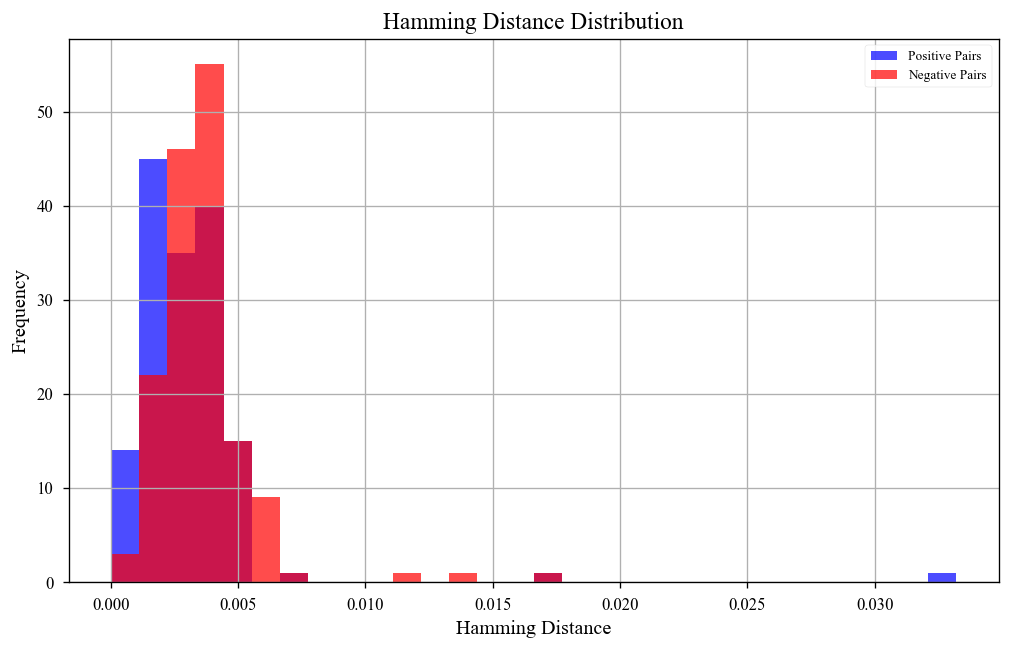

In [ ]:
# Distribution of positive and negative pairs
import random
import matplotlib.pyplot as plt

def calculate_hamming_distribution():
    positive_distances = []
    negative_distances = []

    # Positive pairs: First two images from each folder (000 to 049)
    for folder_id in range(155):
        folder = f"data/{folder_id:03d}/"
        img1 = f"{folder}S6{folder_id:03d}S00.jpg"
        img2 = f"{folder}S6{folder_id:03d}S01.jpg"
        pipeline_1 = IrisPipeline(img1)
        pipeline_2 = IrisPipeline(img2)
        pipeline_1.run_pipeline()
        pipeline_2.run_pipeline()
        results_1 = pipeline_1.get_results()
        results_2 = pipeline_2.get_results()
        try:
            normalized_matrix_1 = daugman_normalization_modified(
                pipeline_1.gray, results_1["pupil_center"], results_1["pupil_radius"], results_1["iris_radius"]
            )
            normalized_matrix_2 = daugman_normalization_modified(
                pipeline_2.gray, results_2["pupil_center"], results_2["pupil_radius"], results_2["iris_radius"]
            )
        except Exception as e:
            print(f"Error processing image {img1}: {e}. Will continue...")
            continue
        
        iris_code_1 = encode_iris(normalized_matrix_1, f=0.5)
        iris_code_2 = encode_iris(normalized_matrix_2, f=0.5)
        distance = hamming_distance(iris_code_1, iris_code_2)
        positive_distances.append(distance)

    # Negative pairs: Randomly sample folders and ensure they are different
    for _ in range(155):
        folder_1_id, folder_2_id = random.sample(range(155), 2)
        folder_1 = f"data/{folder_1_id:03d}/"
        folder_2 = f"data/{folder_2_id:03d}/"
        img1 = f"{folder_1}S6{folder_1_id:03d}S00.jpg"
        img2 = f"{folder_2}S6{folder_2_id:03d}S00.jpg"
        pipeline_1 = IrisPipeline(img1)
        pipeline_2 = IrisPipeline(img2)
        pipeline_1.run_pipeline()
        pipeline_2.run_pipeline()
        results_1 = pipeline_1.get_results()
        results_2 = pipeline_2.get_results()
        try:
            normalized_matrix_1 = daugman_normalization_modified(
                pipeline_1.gray, results_1["pupil_center"], results_1["pupil_radius"], results_1["iris_radius"]
            )
            normalized_matrix_2 = daugman_normalization_modified(
                pipeline_2.gray, results_2["pupil_center"], results_2["pupil_radius"], results_2["iris_radius"]
            )
        except Exception as e:
            print(f"Error processing image {img1}: {e}. Will continue...")
            continue
        iris_code_1 = encode_iris(normalized_matrix_1, f=0.5)
        iris_code_2 = encode_iris(normalized_matrix_2, f=0.5)
        distance = hamming_distance(iris_code_1, iris_code_2)
        negative_distances.append(distance)

    # Plot the distributions

    all_distances = positive_distances + negative_distances
    # Remove outliers
    all_distances = [d for d in all_distances if d < 0.04]  # Remove distances greater than 0.5
    bins = np.linspace(min(all_distances), max(all_distances), 31)  # 20 bins
    plt.figure(figsize=(10, 6))
    plt.hist(positive_distances, bins=bins, alpha=0.7, color="blue", label="Positive Pairs")
    plt.hist(negative_distances, bins=bins, alpha=0.7, color="red", label="Negative Pairs")
    plt.title("Hamming Distance Distribution")
    plt.xlabel("Hamming Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

# Run the function to calculate and plot the distributions
calculate_hamming_distribution()